# PROYECTO 2, PROGRAMACIÓN II: ANÁLISIS DEL IMPACTO DEL COVID-19 EN LOS PRECIOS DE ECOPETROL.

## LIMPIEZA DE LA BASE DE DATOS:

In [3]:
import requests
import pandas as pd

API_KEY = "b752f1dff21944ff9f8b05f37f08c6ee"


url = f"https://api.twelvedata.com/time_series?symbol=EC&exchange=NYSE&interval=1day&apikey={API_KEY}&start_date=2019-01-01&end_date=2023-01-31"

response = requests.get(url)
data = response.json()



In [4]:
import pandas as pd
# Pasar a DataFrame
df = pd.DataFrame(data["values"])
print(df.head())

     datetime      open       high       low     close   volume
0  2023-01-30  11.24000   11.27000        11  11.12000  1996300
1  2023-01-27  11.60000   11.69000  11.19000  11.28000  3050400
2  2023-01-26  11.93000  12.040000     11.75  11.96000  1177400
3  2023-01-25  11.77000   11.81000  11.60000  11.78000  1419100
4  2023-01-24  12.19000   12.19000  11.82000  11.84000  1274400


In [5]:
# Convertir columna 'datetime' a tipo fecha
df["datetime"] = pd.to_datetime(df["datetime"])

# Ordenar de más antiguo a más reciente
df = df.sort_values("datetime")

# Reiniciar índices
df = df.reset_index(drop=True)

print(df.head())
print(df.tail())

    datetime       open      high       low     close   volume
0 2019-01-02   15.60000  16.58000  15.51000  16.46000  1087400
1 2019-01-03   16.56000  16.88000  16.33000      16.5  1099200
2 2019-01-04   16.88000  17.57000  16.84000  17.51000  1240100
3 2019-01-07   17.48000  17.90000  17.36000  17.77000   586500
4 2019-01-08  18.030001  18.30000  17.76000  18.28000   760000
       datetime      open       high       low     close   volume
1022 2023-01-24  12.19000   12.19000  11.82000  11.84000  1274400
1023 2023-01-25  11.77000   11.81000  11.60000  11.78000  1419100
1024 2023-01-26  11.93000  12.040000     11.75  11.96000  1177400
1025 2023-01-27  11.60000   11.69000  11.19000  11.28000  3050400
1026 2023-01-30  11.24000   11.27000        11  11.12000  1996300


In [6]:
import pandas as pd

# Columnas numéricas en formato string
columnas_a_convertir = ["open", "high", "low", "close", "volume"]

# Convertimos esas columnas a float
for col in columnas_a_convertir:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
# Para ver la estructura y el contenido del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  1027 non-null   datetime64[ns]
 1   open      1027 non-null   float64       
 2   high      1027 non-null   float64       
 3   low       1027 non-null   float64       
 4   close     1027 non-null   float64       
 5   volume    1027 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 48.3 KB


In [8]:
# Para generar un resumen estadístico de un DataFrame
df.describe()

,datetime,open,high,low,close,volume
count,1027,1027.000000,1027.000000,1027.000000,1027.000000,1.027000e+03
mean,2021-01-14 03:03:40.837390336,14.271597,14.472892,14.054343,14.260682,1.102903e+06
min,2019-01-02 00:00:00,6.720000,7.260000,6.280000,6.680000,1.410000e+05
25%,2020-01-08 12:00:00,11.390000,11.555000,11.195000,11.345000,6.535500e+05
50%,2021-01-14 00:00:00,13.470000,13.630000,13.250000,13.420000,9.505000e+05
75%,2022-01-20 12:00:00,17.465000,17.650000,17.215000,17.480000,1.320150e+06
max,2023-01-30 00:00:00,22.850000,23.240000,22.760000,23.030001,1.162880e+07
std,NaN,3.512587,3.519420,3.511535,3.516909,7.562916e+05


In [9]:
# Verificar si hay nulos
print(df.isnull().sum())

# Eliminar filas con nulos (si los hay)
df = df.dropna()

# Eliminar duplicados por fecha
df = df.drop_duplicates(subset=["datetime"])


datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64


Interpretación: todas las filas tienen datos completos en esas variables, por lo tanto nos permite tener un análisis más preciso, debido a la falta de valores nulos. Por otro lado, tampoco hay duplicados, ya que no cambió el número de filas.

In [10]:
#Renombrar variables
df = df.rename(columns={
    "datetime": "fecha",
    "open": "apertura",
    "high": "maximo",
    "low": "minimo",
    "close": "cierre",
    "volume": "volumen"
})

## CREACIÓN DE CLASES

### FUNCIÓN 1

In [36]:
# Por medio de esta función se determina si la acción bajó o subió durante el día
def calcular_tendencia(df, col_apertura="apertura", col_cierre="cierre"):
    """
    Determina la tendencia diaria de una acción con base en el precio de apertura y cierre.

    Para cada fila del DataFrame, compara el precio de cierre con el de apertura:
    - Si el cierre es mayor que la apertura, se etiqueta como "subió".
    - En caso contrario, se etiqueta como "bajó".

    Parámetros:
    ----------
    df : pandas.DataFrame
        DataFrame que contiene al menos las columnas de apertura y cierre.
    col_apertura : str, opcional
        Nombre de la columna con los precios de apertura. Por defecto es "apertura".
    col_cierre : str, opcional
        Nombre de la columna con los precios de cierre. Por defecto es "cierre".

    Retorna:
    -------
    pandas.DataFrame
        El mismo DataFrame con una nueva columna llamada "tendencia" que indica si la acción subió o bajó.
    """
    df["tendencia"] = [
        "subió" if cierre > apertura else "bajó"
        for apertura, cierre in zip(df[col_apertura], df[col_cierre])
    ]
    return df



In [37]:
df = calcular_tendencia(df, "apertura", "cierre")
display(df[["apertura", "cierre", "tendencia"]])


,apertura,cierre,tendencia
0,11.240000,11.12,bajó
1,11.600000,11.28,bajó
2,11.930000,11.96,subió
3,11.770000,11.78,subió
4,12.190000,11.84,bajó
...,...,...,...
1022,18.030001,18.28,subió
1023,17.480000,17.77,subió
1024,16.880000,17.51,subió
1025,16.560000,16.50,bajó


El código sirvió para crear una función que compara los precios de apertura y cierre de una acción y determina si durante el día subió o bajó. Con esto, añadimos al DataFrame una nueva columna llamada “tendencia”, que facilita identificar de un vistazo los días buenos y malos para invertir.

In [13]:
def ver_resultado_fecha(df, col_fecha="fecha"):

    fecha = input("Ingrese la fecha que desea consultar (ejemplo: 2019-05-10): ")

    resultado = df[df[col_fecha] == fecha][["apertura", "cierre", "tendencia"]]

    if resultado.empty:
        print(f"No se encontró información para la fecha {fecha}.")
    else:
        display(resultado)

# Ejemplo de uso
ver_resultado_fecha(df)


Ingrese la fecha que desea consultar (ejemplo: 2019-05-10): 2022-05-26


,apertura,cierre,tendencia
857,14.95,15.09,subió


En este código se puede ver el resultado de la acción en una fecha en específico

### FUNCIÓN 2

In [14]:
# Esta función nos ayuda a ver en qué días es pertinente invertir o no invertir en la acción de Ecopetrol
def dias_para_invertir(df):
    dias_buenos = [fecha for fecha, o, c in zip(df["fecha"], df["apertura"], df["cierre"]) if c > o]
    dias_malos  = [fecha for fecha, o, c in zip(df["fecha"], df["apertura"], df["cierre"]) if c <= o]

    return {
        "dias_buenos": dias_buenos,
        "dias_malos": dias_malos
    }


In [15]:
resultado = dias_para_invertir(df)

print("Días buenos para invertir:")
print(resultado["dias_buenos"])

print("\nDías malos para invertir:")
print(resultado["dias_malos"])


Días buenos para invertir:
[Timestamp('2019-01-02 00:00:00'), Timestamp('2019-01-04 00:00:00'), Timestamp('2019-01-07 00:00:00'), Timestamp('2019-01-08 00:00:00'), Timestamp('2019-01-09 00:00:00'), Timestamp('2019-01-10 00:00:00'), Timestamp('2019-01-14 00:00:00'), Timestamp('2019-01-15 00:00:00'), Timestamp('2019-01-16 00:00:00'), Timestamp('2019-01-17 00:00:00'), Timestamp('2019-01-24 00:00:00'), Timestamp('2019-01-28 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2019-01-30 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-04 00:00:00'), Timestamp('2019-02-05 00:00:00'), Timestamp('2019-02-06 00:00:00'), Timestamp('2019-02-08 00:00:00'), Timestamp('2019-02-12 00:00:00'), Timestamp('2019-02-14 00:00:00'), Timestamp('2019-02-15 00:00:00'), Timestamp('2019-02-19 00:00:00'), Timestamp('2019-02-20 00:00:00'), Timestamp('2019-02-22 00:00:00'), Timestamp('2019-02-25 00:00:00'), Timestamp('2019-02-26 00:00:00'), Timestamp('2019-03-01 00:00:00'), Timestamp('2019-03-0

El código sirve para mostrar en qué días la acción subió y valía la pena invertir, y en cuáles bajó y no convenía hacerlo. Así nos ayuda a separar fácilmente los días buenos de los malos para tomar decisiones de inversión.

In [16]:
#Esta lista se usa para saber si la acción subió o bajó, es otra forma de hacer la función #1 del apartado de clases
df["tendencia"] = ["subió" if cierre > apertura else "bajó" for apertura, cierre in zip(df["apertura"], df["cierre"])]
display(df[["apertura", "cierre", "tendencia"]])

,apertura,cierre,tendencia
0,15.600000,16.46,subió
1,16.560000,16.50,bajó
2,16.880000,17.51,subió
3,17.480000,17.77,subió
4,18.030001,18.28,subió
...,...,...,...
1022,12.190000,11.84,bajó
1023,11.770000,11.78,subió
1024,11.930000,11.96,subió
1025,11.600000,11.28,bajó


In [17]:
len(df[df["tendencia"] == "subió"])

494

In [18]:
len(df[df["tendencia"] == "bajó"])

533

La acción de ecopetrol bajó en más días que en los que subió

In [19]:
#Se construye un diccionario en la que la clave es el nombre de la columna, y el valor es el promedio de esa columna
promedios = {col: df[col].mean() for col in ["apertura", "maximo", "minimo", "cierre"]}
print(promedios)

{'apertura': np.float64(14.271596879259981), 'maximo': np.float64(14.472891919182084), 'minimo': np.float64(14.054342746835442), 'cierre': np.float64(14.260681598831546)}


In [20]:
# Muestra una lista de precios de cierre mayores a 20 y cuantos datos hay (mostrando en cuantos días el cierre es mayor a 20)
cierres_altos = df[df['cierre'] > 20]['cierre'].tolist()
print(cierres_altos)
print(f"Number of days with closing price > 20: {len(cierres_altos)}")

[20.23, 20.61, 21.059999, 20.24, 20.49, 20.78, 20.8, 20.51, 20.23, 20.21, 20.52, 21.2, 21.09, 21.38, 22.25, 22.41, 22.81, 23.030001, 21.75, 21.7, 22.14, 21.37, 21.25, 21.44, 21.88, 21.84, 21.83, 21.4, 21.58, 21.97, 21.61, 21.86, 21.32, 21.0, 20.56, 20.64, 20.32, 20.81, 20.1, 20.19, 20.59, 20.7, 20.27, 20.22, 20.27, 20.31, 20.48, 20.4, 20.5, 20.34, 20.45, 20.71, 20.95, 20.6, 20.46, 20.41, 20.37, 20.049999, 20.38, 20.16, 20.2]
Number of days with closing price > 20: 61


In [21]:
# Clasifica el volumen en categorias (alto si el volumen es mayor al promedio y bajo si el volumen es menor o igual al promedio)
df["volumen_categoria"] = ["Alto" if v > df["volumen"].mean() else "Bajo" for v in df["volumen"]]
display(df[["volumen", "volumen_categoria"]])

,volumen,volumen_categoria
0,1087400,Bajo
1,1099200,Bajo
2,1240100,Alto
3,586500,Bajo
4,760000,Bajo
...,...,...
1022,1274400,Alto
1023,1419100,Alto
1024,1177400,Alto
1025,3050400,Alto


##Funciones con Numpy: Cálculo de Rendimientos y Estadísticas

In [22]:
import numpy as np

# Función 1: Rendimientos diarios con numpy
def calcular_rendimientos(df):
    df["rendimiento"] = np.log(df["cierre"] / df["cierre"].shift(1))
    return df[["fecha", "cierre", "rendimiento"]]

# Función 2: Estadísticas descriptivas con numpy
def estadisticas_rendimientos(df):
    rend = df["rendimiento"].dropna()
    return {
        "media": np.mean(rend),
        "mediana": np.median(rend),
        "desviacion": np.std(rend),
        "maximo": np.max(rend),
        "minimo": np.min(rend)
    }


In [23]:
# Llamamos a la función 1
df = calcular_rendimientos(df)
print(df.head())

# Llamamos a la función 2
stats = estadisticas_rendimientos(df)
print("Estadísticas de los rendimientos:", stats)


       fecha  cierre  rendimiento
0 2019-01-02   16.46          NaN
1 2019-01-03   16.50     0.002427
2 2019-01-04   17.51     0.059412
3 2019-01-07   17.77     0.014739
4 2019-01-08   18.28     0.028296
Estadísticas de los rendimientos: {'media': np.float64(-0.0003822494214683135), 'mediana': np.float64(0.0), 'desviacion': 0.031149942028051984, 'maximo': 0.13921645625913096, 'minimo': -0.29727496160881944}


####Conclusión:

Los rendimientos diarios de Ecopetrol presentan en promedio una variación cercana a cero, lo que refleja estabilidad general en el largo plazo; sin embargo, la desviación estándar del 3,1% evidencia una alta volatilidad en el corto plazo. Se observan días con incrementos significativos (hasta +13,9%) y caídas pronunciadas (hasta -29,7%), lo cual coincide con los periodos de mayor incertidumbre durante la pandemia de COVID-19. Estos resultados muestran que, aunque la acción tendió a recuperarse, estuvo expuesta a fuertes fluctuaciones derivadas de la pandemia.


## GRÁFICOS

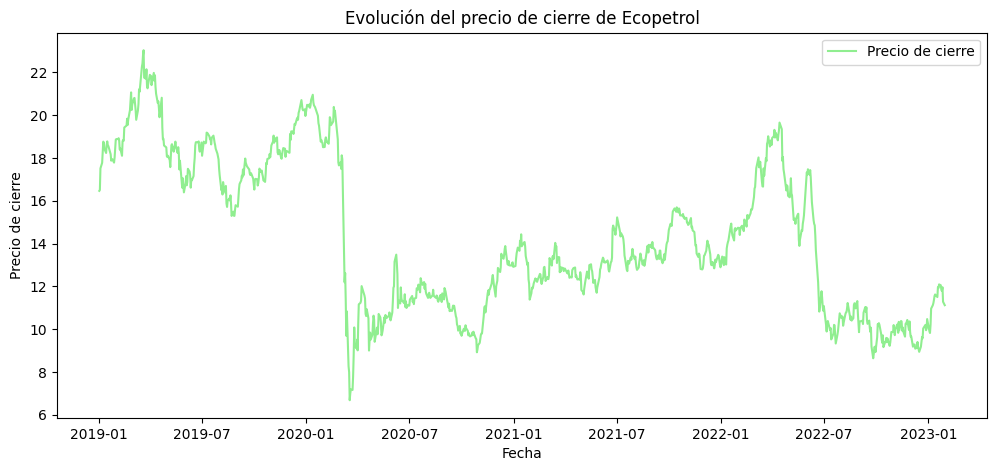

In [24]:
# Gráfica que muestra la evolución del precio de cierre a lo largo del tiempo
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df["fecha"], df["cierre"], label="Precio de cierre", color="lightgreen")
plt.title("Evolución del precio de cierre de Ecopetrol")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.show()


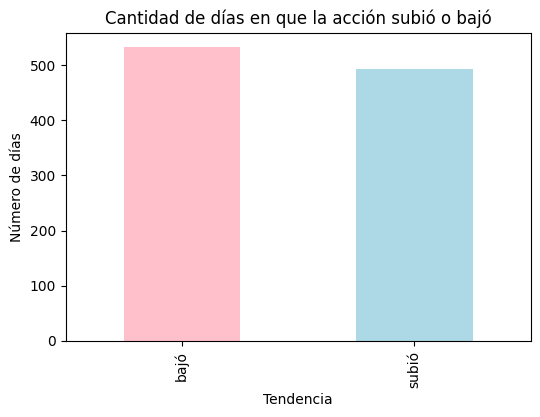

In [27]:
# Esta gráfica resume el conteo histórico de la acción, en si subió o bajó.
df["tendencia"] = ["subió" if float(cierre) > float(apertura) else "bajó" for apertura, cierre in zip(df["apertura"], df["cierre"])]

df["tendencia"].value_counts().plot(kind="bar", color=["pink", "lightblue"], figsize=(6,4))
plt.title("Cantidad de días en que la acción subió o bajó")
plt.xlabel("Tendencia")
plt.ylabel("Número de días")
plt.show()

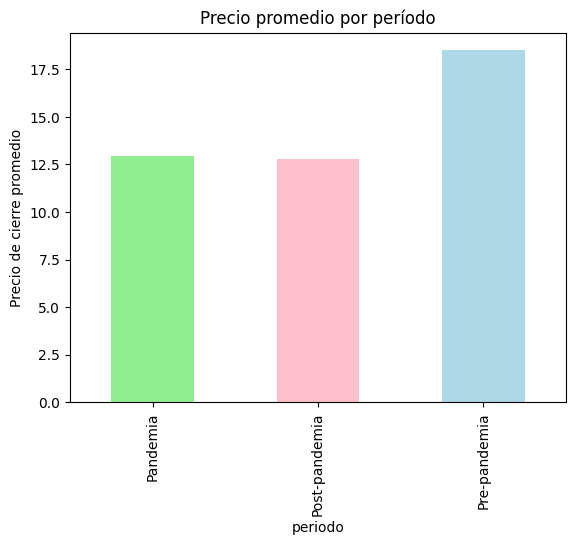

In [28]:
# Esta gráfica nos permite comprara el precio promedio de la acción de Ecopetrol en la pre-pandemia, en la pandemia y post-pandemia
df["fecha"] = pd.to_datetime(df["fecha"])

def periodo(fecha):
    if fecha.year == 2019:
        return "Pre-pandemia"
    elif fecha.year in [2020, 2021]:
        return "Pandemia"
    else:
        return "Post-pandemia"

df["periodo"] = df["fecha"].apply(periodo)

df.groupby("periodo")["cierre"].mean().plot(kind="bar", color=["lightgreen","pink","lightblue"])
plt.title("Precio promedio por período")
plt.ylabel("Precio de cierre promedio")
plt.show()

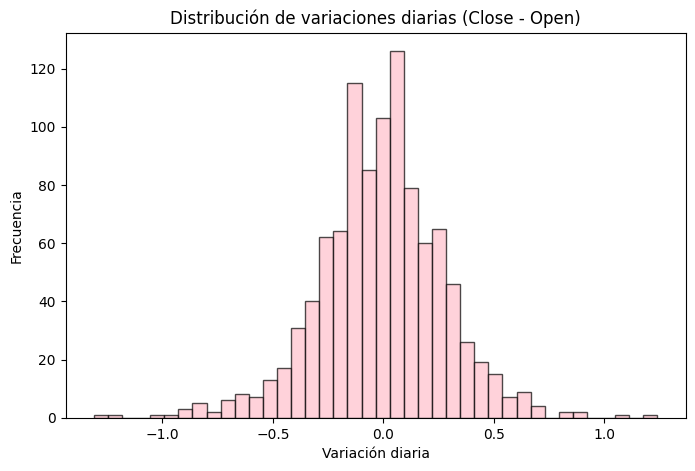

In [29]:
# Calculamos la variación diaria de la acción como (cierre - apertura)
df["variacion"] = df["cierre"] - df["apertura"]
# Creamos un histograma para visualizar la distribución de las variaciones diarias.
plt.figure(figsize=(8,5))
plt.hist(df["variacion"], bins=40, color="pink", edgecolor="black", alpha=0.7)
plt.title("Distribución de variaciones diarias (Close - Open)")
plt.xlabel("Variación diaria")
plt.ylabel("Frecuencia")
plt.show()